In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from scipy.stats import zscore
from scipy import stats
#importing cross_val_score for validation purposes only
from sklearn.model_selection import cross_val_score


# 1. Importing datasets

In [22]:
names1=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'over-50K']
dataset1_train = pd.read_csv('adult_train.csv', index_col=False, names=names1, sep=',\s', na_values=['?'], engine='python')
dataset1_test = pd.read_csv('adult_test.csv', index_col=False, names=names1, sep=',\s', na_values=['?', 'nan', '|1x3 Cross validator'], engine='python')

names2=['A1-Time','A2','A3','A4','A5','A6','A7','A8','A9','LABEL']
dataset2_trn_full = pd.read_csv('shuttle_trn.csv', index_col=False, names=names2, sep=' ', engine='python') 
dataset2_test = pd.read_csv('shuttle_tst.csv', index_col=False, names=names2, sep=' ', engine='python')

# 2. Preprocessing

## 2.1 - Dataset 1: Adults

count             30162
unique               41
top       United-States
freq              27504
Name: native-country, dtype: object
                     age    fnlwgt  education-num       sex  capital-gain  \
age             1.000000 -0.076511       0.043526  0.081993      0.080154   
fnlwgt         -0.076511  1.000000      -0.044992  0.025362      0.000422   
education-num   0.043526 -0.044992       1.000000  0.006157      0.124416   
sex             0.081993  0.025362       0.006157  1.000000      0.048814   
capital-gain    0.080154  0.000422       0.124416  0.048814      1.000000   
capital-loss    0.060165 -0.009750       0.079646  0.047011     -0.032229   
hours-per-week  0.101599 -0.022886       0.152522  0.231268      0.080432   
native-country  0.016259 -0.083390       0.127207 -0.003006      0.012375   
over-50K        0.241998 -0.008957       0.335286  0.216699      0.221196   

                capital-loss  hours-per-week  native-country  over-50K  
age                 0.06

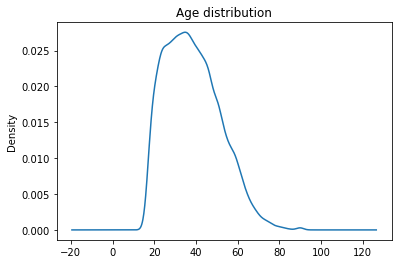

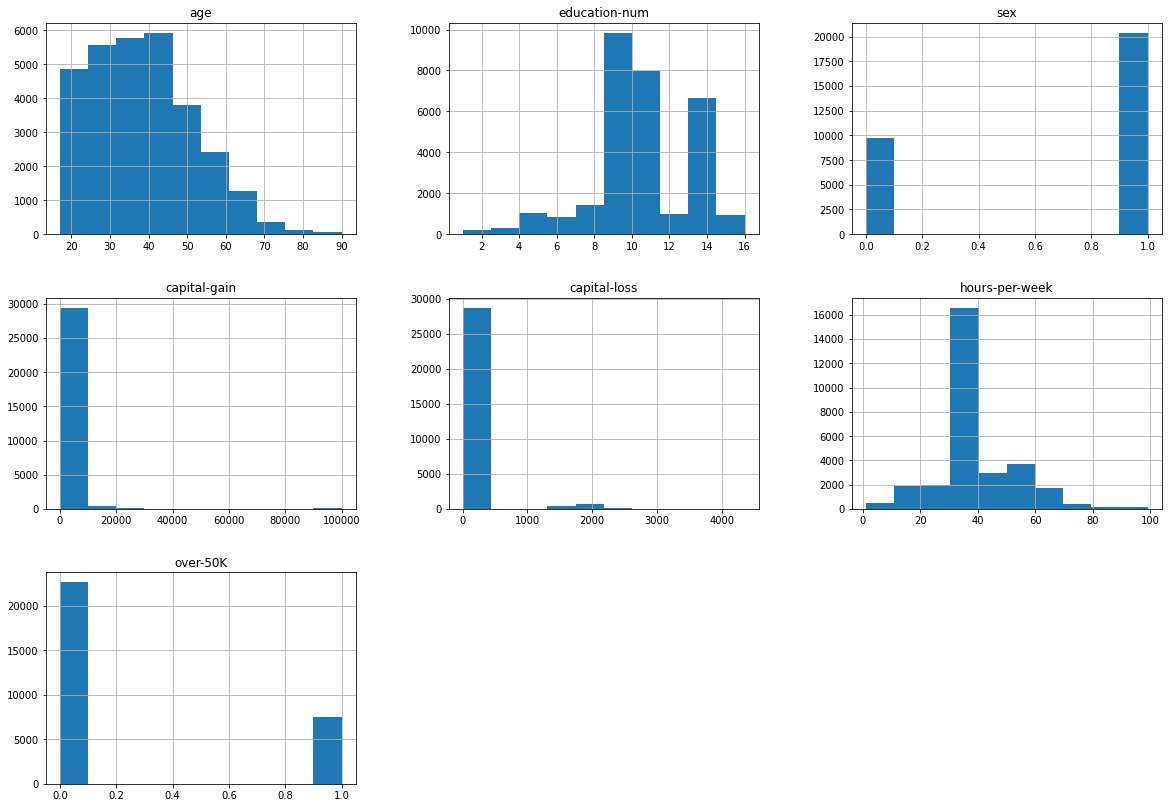

In [23]:
# Remove instances with missing/invalid data entries
dataset1_train.dropna(axis=0, how='any', inplace=True)
dataset1_test.dropna(axis=0, how='any', inplace=True)

# Encode Over 50K as 1
dataset1_train['over-50K'] = dataset1_train['over-50K'].map({'>50K': 1, '<=50K': 0})
dataset1_test['over-50K'] = dataset1_test['over-50K'].map({'>50K.': 1, '<=50K.': 0})

print(dataset1_train['native-country'].describe()) 
# Since 91% of native-country data is US, we will categorize this column as "US" and "non-US".

# Encode US as 1 and non-US as 0
dataset1_train['native-country'] = np.where(dataset1_train['native-country']=='United-States', 1, 0)
dataset1_test['native-country'] = np.where(dataset1_test['native-country']=='United-States', 1, 0)

# Encode Male as 1
dataset1_train['sex'] = dataset1_train['sex'].map({'Male': 1, 'Female': 0})
dataset1_test['sex'] = dataset1_test['sex'].map({'Male': 1, 'Female': 0})

# Correlation
correlations = dataset1_train.corr(method="pearson")
print(correlations)

# From the above correlations, we can interpret that 'fnlgwt' and 'native-country' are not relevant to predicting the salary as their correlation is below 0.09.

# Remove uncorrelated columns
dataset1_train = dataset1_train.drop(columns=['fnlwgt', 'native-country'])
dataset1_test = dataset1_test.drop(columns=['fnlwgt', 'native-country'])

# Visualize age distribution
dataset1_train.age.plot(kind='kde')
plt.title('Age distribution')
plt.show()

# Visualize all numerical categories
dataset1_train.hist(figsize=(20, 14))

# Visualize categorical data
dataset1_train['education'].value_counts()
pd.crosstab(dataset1_train['education-num'], columns=dataset1_train['education'])

# Remove education-num as it gives no more information than education
dataset1_train = dataset1_train.drop(columns='education-num')
dataset1_test = dataset1_test.drop(columns='education-num')

## 2.2 - Dataset 2: Shuttle

          A1-Time        A2        A3        A4        A5        A6        A7  \
A1-Time  1.000000  0.066365  0.262622 -0.007774 -0.051460  0.007306 -0.757307   
A2       0.066365  1.000000 -0.013422 -0.001609  0.000373 -0.001826 -0.070628   
A3       0.262622 -0.013422  1.000000  0.042157  0.255181 -0.002909  0.430019   
A4      -0.007774 -0.001609  0.042157  1.000000 -0.004767  0.008286  0.036169   
A5      -0.051460  0.000373  0.255181 -0.004767  1.000000  0.103159  0.221277   
A6       0.007306 -0.001826 -0.002909  0.008286  0.103159  1.000000 -0.008569   
A7      -0.757307 -0.070628  0.430019  0.036169  0.221277 -0.008569  1.000000   
A8       0.168417 -0.005827  0.155282  0.022352 -0.914963 -0.105569 -0.053010   
A9       0.526896  0.031235 -0.091279  0.000410 -0.875212 -0.083378 -0.555205   
LABEL    0.737641 -0.003978  0.145267 -0.003180 -0.430602  0.000707 -0.593932   

               A8        A9     LABEL  
A1-Time  0.168417  0.526896  0.737641  
A2      -0.005827  0.031235 

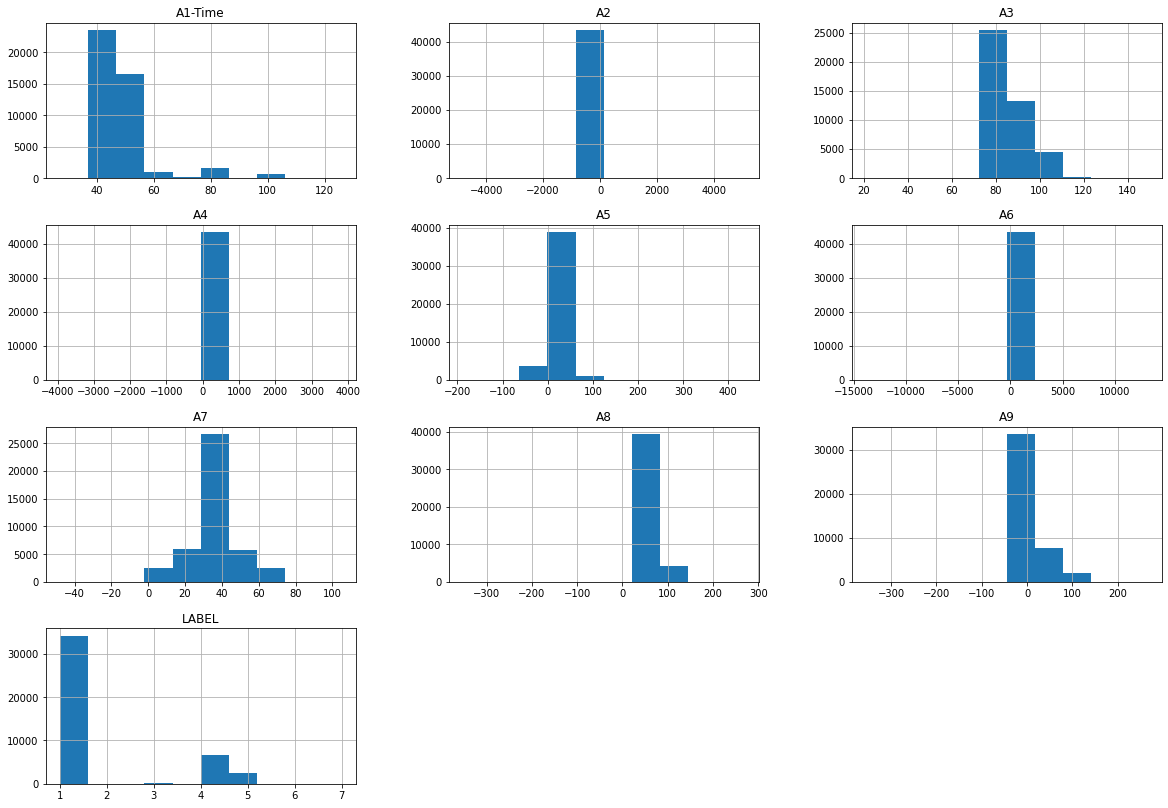

In [24]:
# Visualize all numerical categories
dataset2_trn_full.hist(figsize=(20, 14))

# Correlation
correlations = dataset2_trn_full.corr(method="pearson")
print(correlations)

# From the above correlations, we can interpret that A2,A4, and A6 are not relevant to predicting the label as their correlation is below 0.09.

# Remove uncorrelated columns
dataset2_trn_full = dataset2_trn_full.drop(columns=['A2', 'A4','A6'])
dataset2_test = dataset2_test.drop(columns=['A2', 'A4','A6'])

# 3. One hot encoding

## 3.1 - Dataset 1

In [25]:
# Convert discrete variables into multiple variables using one-hot encoding
# Discrete columns: workclass, education, marital-status, occupation, relationship, sex, native-country
encoder = ce.OneHotEncoder(cols=['workclass', 'education', 'marital-status', 'occupation', 'race', 'relationship'], use_cat_names=True)
train_encoded_1 = encoder.fit_transform(dataset1_train)
test_encoded_1 = encoder.transform(dataset1_test)

names_1_encoded = train_encoded_1.columns

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## 3.2 - Dataset 2

In [26]:
# No categorical data to encode

# 4. Normalize data

## 4.1 - Dataset 1

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'workclass_State-gov'}>,
        <AxesSubplot:title={'center':'workclass_Self-emp-not-inc'}>,
        <AxesSubplot:title={'center':'workclass_Private'}>,
        <AxesSubplot:title={'center':'workclass_Federal-gov'}>,
        <AxesSubplot:title={'center':'workclass_Local-gov'}>,
        <AxesSubplot:title={'center':'workclass_Self-emp-inc'}>,
        <AxesSubplot:title={'center':'workclass_Without-pay'}>],
       [<AxesSubplot:title={'center':'education_Bachelors'}>,
        <AxesSubplot:title={'center':'education_HS-grad'}>,
        <AxesSubplot:title={'center':'education_11th'}>,
        <AxesSubplot:title={'center':'education_Masters'}>,
        <AxesSubplot:title={'center':'education_9th'}>,
        <AxesSubplot:title={'center':'education_Some-college'}>,
        <AxesSubplot:title={'center':'education_Assoc-acdm'}>,
        <AxesSubplot:title={'center':'education_7th-8th'}>],
       [<AxesSubplot:ti

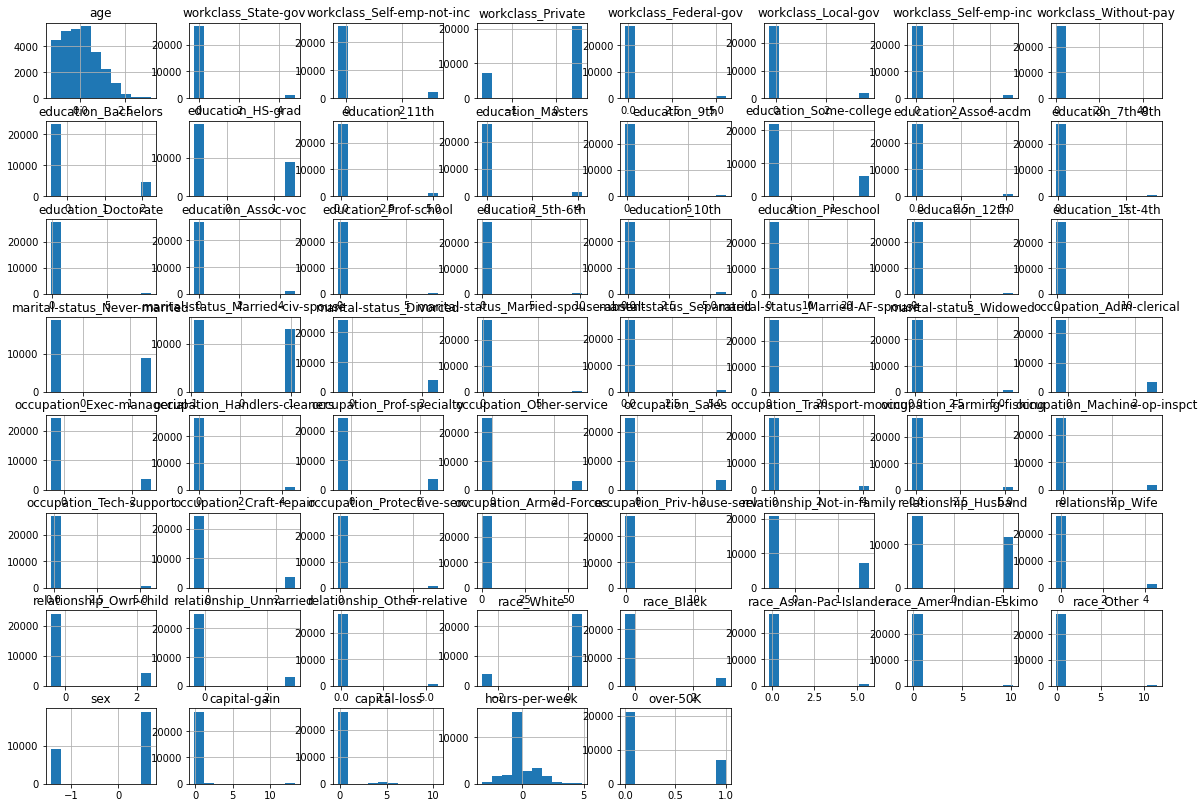

In [27]:
x_d1=train_encoded_1.loc[:, 'age':'hours-per-week']
y_d1=train_encoded_1['over-50K']

scaler = preprocessing.StandardScaler()

# fit the scaler 
scaler.fit(x_d1)

# transform the data
scaled_data = scaler.transform(x_d1)
normalized_dataset_1 = pd.DataFrame(scaled_data, columns=x_d1.columns)
normalized_dataset_1 = pd.concat([normalized_dataset_1, y_d1], axis=1)
normalized_dataset_1.dropna(axis=0, how='any', inplace=True)
normalized_dataset_1.hist(figsize=(20, 14))

## 4.2 - Dataset 2

array([[<AxesSubplot:title={'center':'A1-Time'}>,
        <AxesSubplot:title={'center':'A3'}>,
        <AxesSubplot:title={'center':'A5'}>],
       [<AxesSubplot:title={'center':'A7'}>,
        <AxesSubplot:title={'center':'A8'}>,
        <AxesSubplot:title={'center':'A9'}>],
       [<AxesSubplot:title={'center':'LABEL'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

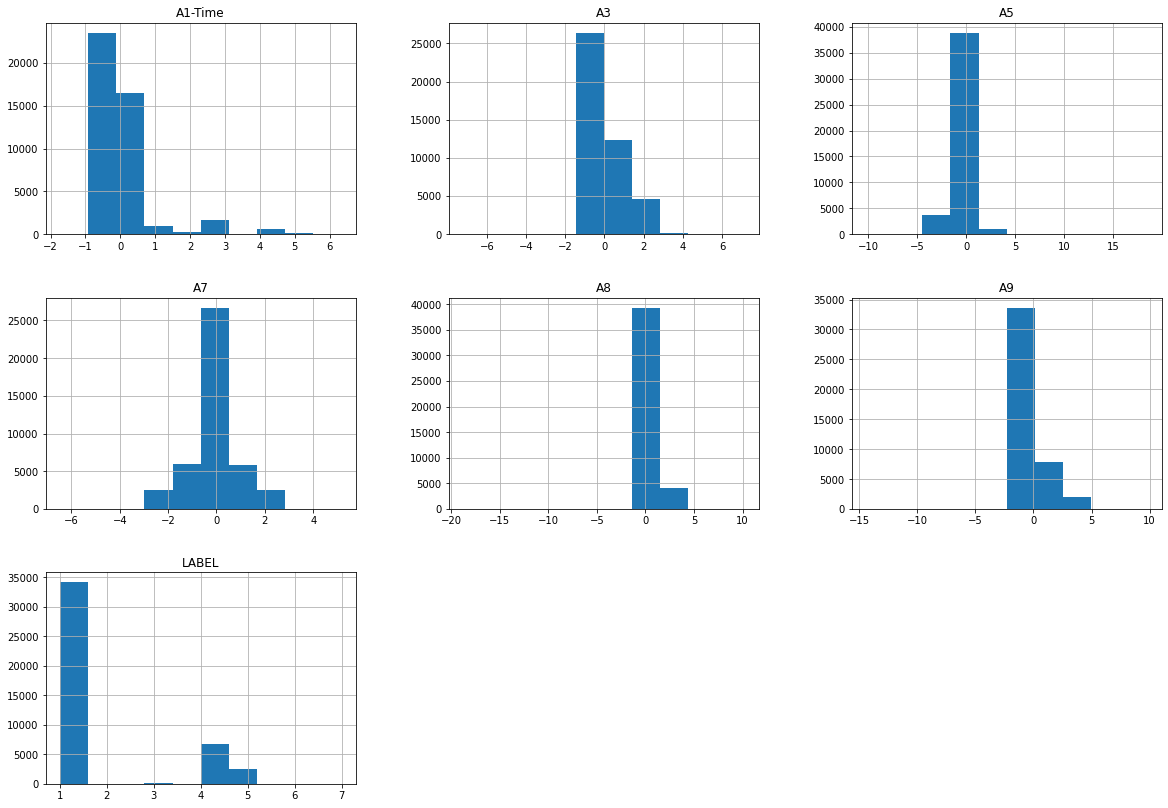

In [28]:
# Normalizing data since scales of some attributes are drastically different
names2_x=['A1-Time','A3','A5','A7','A8','A9']
x_d2=dataset2_trn_full.loc[:,'A1-Time':'A9']
y_d2=dataset2_trn_full.loc[:,'LABEL']

scaler = preprocessing.StandardScaler()

# fit the scaler 
scaler.fit(x_d2)

# transform the data
x_train_normal = scaler.transform(x_d2)

normalized_dataset_2 = pd.DataFrame(x_train_normal, columns=x_d2.columns)
normalized_dataset_2 = pd.concat([normalized_dataset_2, y_d2], axis=1)
normalized_dataset_2.dropna(axis=0, how='any', inplace=True)
normalized_dataset_2.hist(figsize=(20, 14))

# normalized_xd2 = pd.DataFrame(x_train_normal, columns=names2_x)
# normalized_xd2.hist(figsize=(20, 14))

# 5. Helpers

In [29]:
accuracy= lambda y, yh: np.mean(y==yh)

def splitTraining(p_val,num_instances):
    n_val=num_instances//p_val
    np.random.seed(5)
    inds = np.random.permutation(num_instances)
    x_val2,y_val2=normalized_dataset_2.loc[inds[:n_val],:],y_d2.loc[inds[:n_val]] # Function specific to dataset #2
    x_train2,y_train2=normalized_dataset_2.loc[inds[n_val:],:],y_d2.loc[inds[n_val:]]
    
    return n_val, x_val2,y_val2, x_train2, y_train2

# Note: Inspired from cross validation code given in class
def cross_validate(total_nval, n_folds=5):
    #get the number of data samples in each split
    n_val = total_nval // n_folds
    np.random.seed(0)
    inds = np.random.permutation(total_nval)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexess
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, total_nval))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

def findBestK(x, y, title):
    (nb_instances, nb_features) = x.shape
    K_list = range(1, 30)
    num_folds = 5
    best_k = 0
    best_acc = 0
    err_train, err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))
    ref_val_err=np.zeros(len(K_list))
    for i, K in enumerate(K_list):
        # Find the validation errors for num_folds splits for a given K
        for f, (tr, val) in enumerate(cross_validate(nb_instances, num_folds)):
            model = neighbors.KNeighborsClassifier(n_neighbors=K)
            model = model.fit(x[tr], y[tr])
            y_pred = model.predict(x[val])
            acc = accuracy_score(y_pred, y[val])
            err_valid[i, f] = 1 - acc

            if acc > best_acc:
                best_k = K
                best_acc = acc

        model = neighbors.KNeighborsClassifier(n_neighbors=K)
        model = model.fit(x, y)
        y_pred = model.predict(x)
        acc = accuracy_score(y_pred, y)
        err_train[i] = (1 - acc)
        
        ref_val_err[i]=1-cross_val_score(model, x, y, cv=5).mean()

    plt.plot(K_list, err_train,  label='Train')
    plt.plot(K_list, ref_val_err,  label='Reference validation')
    plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='Validation')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('Misclassitifaction error')
    plt.title(title)
    plt.show()

    return best_acc, best_k

def findBestWeightedK(x, y, title):
    (nb_instances, nb_features) = x.shape
    K_list = range(1, 30)
    num_folds = 5
    best_k = 0
    best_acc = 0
    err_train, err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))
    ref_val_err=np.zeros(len(K_list))
    for i, K in enumerate(K_list):
        # Find the validation errors for num_folds splits for a given K
        for f, (tr, val) in enumerate(cross_validate(nb_instances, num_folds)):
            model = neighbors.KNeighborsClassifier(n_neighbors=K, weights='distance')
            model = model.fit(x[tr], y[tr])
            y_pred = model.predict(x[val])
            acc = accuracy_score(y_pred, y[val])
            err_valid[i, f] = 1 - acc

            if acc > best_acc:
                best_k = K
                best_acc = acc

        model = neighbors.KNeighborsClassifier(n_neighbors=K)
        model = model.fit(x, y)
        y_pred = model.predict(x)
        acc = accuracy_score(y_pred, y)
        err_train[i] = (1 - acc)
        ref_val_err[i]=1-cross_val_score(model, x, y, cv=5).mean()

    plt.plot(K_list, ref_val_err,  label='Reference validation')

    plt.plot(K_list, err_train,  label='Train')
    plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='Validation')
    plt.legend()
    plt.xlabel('K (number of neighbours) - Weighted')
    plt.ylabel('Misclassitifaction error')
    plt.title(title)
    plt.show()

    return best_acc, best_k

def findBestDepth(x, y, title):
    (nb_instances, nb_features) = x.shape

    depth_list = range(1, 30)
    num_folds = 5
    best_depth = 0
    best_acc = 0
    err_train, err_valid = np.zeros(len(depth_list)), np.zeros((len(depth_list), num_folds))
    ref_val_err=np.zeros(len(depth_list))
    for i, D in enumerate(depth_list):
        # Find the validation errors for num_folds splits for a given depth
        for f, (tr, val) in enumerate(cross_validate(nb_instances, num_folds)):
            model = tree.DecisionTreeClassifier(max_depth=D)
            model = model.fit(x[tr], y[tr])

            y_pred = model.predict(x[val])
            acc = accuracy_score(y_pred, y[val])
            err_valid[i, f] = 1 - acc

            if acc > best_acc:
                best_depth = D
                best_acc = acc

        model = tree.DecisionTreeClassifier(max_depth=D)
        model = model.fit(x, y)
        y_pred = model.predict(x)
        acc = accuracy_score(y_pred, y)
        err_train[i] = (1 - acc)
        ref_val_err[i]=1-cross_val_score(model, x, y, cv=5).mean()


    plt.plot(depth_list, ref_val_err,  label='Reference validation')
    plt.plot(depth_list, err_train,  label='Train')   
    plt.errorbar(depth_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='Validation')
    plt.legend()
    plt.xlabel('Max Depth')
    plt.ylabel('Misclassitifaction error')
    plt.title(title)
    plt.show()

    return best_acc, best_depth

def findBestDepthWithEntropy(x, y, title):
    (nb_instances, nb_features) = x.shape
    
    depth_list = range(1, 30)
    num_folds = 5
    best_depth = 0
    best_acc = 0
    err_train, err_valid = np.zeros(len(depth_list)), np.zeros((len(depth_list), num_folds))
    ref_val_err=np.zeros(len(depth_list))
    for i, D in enumerate(depth_list):
        # Find the validation errors for num_folds splits for a given depth
        for f, (tr, val) in enumerate(cross_validate(nb_instances, num_folds)):
            model = tree.DecisionTreeClassifier(max_depth=D, criterion='entropy')
            model = model.fit(x[tr], y[tr])

            y_pred = model.predict(x[val])
            acc = accuracy_score(y_pred, y[val])
            err_valid[i, f] = 1 - acc

            if acc > best_acc:
                best_depth = D
                best_acc = acc
                
        model = tree.DecisionTreeClassifier(max_depth=D)
        model = model.fit(x, y)
        y_pred = model.predict(x)
        acc = accuracy_score(y_pred, y)
        err_train[i] = (1 - acc)
        ref_val_err[i]=1-cross_val_score(model, x, y, cv=5).mean()


    plt.plot(depth_list, ref_val_err,  label='Reference validation')

    plt.plot(depth_list, err_train,  label='Train')   
    plt.errorbar(depth_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='Validation')
    plt.legend()
    plt.xlabel('Max Depth (with Entropy criterion)')
    plt.ylabel('Misclassitifaction error')
    plt.title(title)
    plt.show()

    return best_acc, best_depth

# 6. KNN

## 6.1 - Dataset 1

In [30]:
'''# Data splits (UNORMALIZED)
x, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()

# Split further for testing purposes (growing samples)
data_30 = train_encoded_1.sample(frac=0.30)
x_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()

data_20 = train_encoded_1.sample(frac=0.20)
x_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()

data_10 = train_encoded_1.sample(frac=0.10)
x_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()

# With 10% of data
best_acc, best_k = findBestK(x_10, y_10, 'Dataset 1 - 10 pct - KNN - Unormalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_k = findBestK(x_20, y_20, 'Dataset 1 - 20 pct - KNN - Unormalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_k = findBestK(x_30, y_30, 'Dataset 1 - 30 pct - KNN - Unormalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_k = findBestK(x, y, 'Dataset 1 - 100 pct - KNN - Unormalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')

#########################################
# Normalized data (10%, 20%, 30%, 100%) #
#########################################

# Split the data
x_normalized, y_normalized = normalized_dataset_1.iloc[:,:-1].to_numpy(), normalized_dataset_1['over-50K'].to_numpy()

# Split further for testing purposes (growing samples)
normalized_data_30 = normalized_dataset_1.sample(frac=0.30)
x_30_normalized, y_30_normalized = normalized_data_30.iloc[:,:-1].to_numpy(), normalized_data_30['over-50K'].to_numpy()

normalized_data_20 = normalized_dataset_1.sample(frac=0.20)
x_20_normalized, y_20_normalized = normalized_data_20.iloc[:,:-1].to_numpy(), normalized_data_20['over-50K'].to_numpy()

normalized_data_10 = normalized_dataset_1.sample(frac=0.10)
x_10_normalized, y_10_normalized = normalized_data_10.iloc[:,:-1].to_numpy(), normalized_data_10['over-50K'].to_numpy()

# With 10% of data
best_acc, best_k = findBestK(x_10_normalized, y_10_normalized, 'Dataset 1 - 10 pct - KNN - Normalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_k = findBestK(x_20_normalized, y_20_normalized, 'Dataset 1 - 20 pct - KNN - Normalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_k = findBestK(x_30_normalized, y_30_normalized, 'Dataset 1 - 30 pct - KNN - Normalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_k = findBestK(x_normalized, y_normalized, 'Dataset 1 - 100 pct - KNN - Normalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')'''

"# Data splits (UNORMALIZED)\nx, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()\n\n# Split further for testing purposes (growing samples)\ndata_30 = train_encoded_1.sample(frac=0.30)\nx_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()\n\ndata_20 = train_encoded_1.sample(frac=0.20)\nx_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()\n\ndata_10 = train_encoded_1.sample(frac=0.10)\nx_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()\n\n# With 10% of data\nbest_acc, best_k = findBestK(x_10, y_10, 'Dataset 1 - 10 pct - KNN - Unormalized')\nprint('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')\nprint('-------------------------------------------------------------------------------------------\n')\n\n# With 20% of data\nbest_acc, best_k = findBestK(x_20, y_20, 'Dataset 1 - 20 pct - KNN - Unormalized')\nprint('20 percent o

### Weighted KNN - Dataset 1

In [31]:
'''# With 10% of data
best_acc, best_k = findBestWeightedK(x_10, y_10, 'Dataset 1 - 10 pct - KNN weighted - Unormalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_k = findBestWeightedK(x_20, y_20, 'Dataset 1 - 20 pct - KNN weighted - Unormalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_k = findBestWeightedK(x_30, y_30, 'Dataset 1 - 30 pct - KNN weighted - Unormalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_k = findBestWeightedK(x, y, 'Dataset 1 - 100 pct - KNN weighted - Unormalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')

#########################################
# Normalized data (10%, 20%, 30%, 100%) #
#########################################

# With 10% of data
best_acc, best_k = findBestWeightedK(x_10_normalized, y_10_normalized, 'Dataset 1 - 10 pct - KNN weighted - Normalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_k = findBestWeightedK(x_20_normalized, y_20_normalized, 'Dataset 1 - 20 pct - KNN weighted - Normalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_k = findBestWeightedK(x_30_normalized, y_30_normalized, 'Dataset 1 - 30 pct - KNN weighted - Normalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_k = findBestWeightedK(x_normalized, y_normalized, 'Dataset 1 - 100 pct - KNN weighted - Normalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')'''

"# With 10% of data\nbest_acc, best_k = findBestWeightedK(x_10, y_10, 'Dataset 1 - 10 pct - KNN weighted - Unormalized')\nprint('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')\nprint('-------------------------------------------------------------------------------------------\n')\n\n# With 20% of data\nbest_acc, best_k = findBestWeightedK(x_20, y_20, 'Dataset 1 - 20 pct - KNN weighted - Unormalized')\nprint('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')\nprint('-------------------------------------------------------------------------------------------\n')\n\n# With 30% of data\nbest_acc, best_k = findBestWeightedK(x_30, y_30, 'Dataset 1 - 30 pct - KNN weighted - Unormalized')\nprint('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')\nprint('---------------------------------------------------------

### Results (KNN)
The best model for KNN is obtained with K = 21 on unormalized data (accuracy = 85.2%)

### 6.1.1 Apply model on test (dataset 1)

In [32]:
'''x_test, y_test = test_encoded_1.iloc[:,:-1].to_numpy(), test_encoded_1['over-50K'].to_numpy()

# 100 %
best_model = neighbors.KNeighborsClassifier(n_neighbors=21)
best_model.fit(x, y)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 30 %
best_model = neighbors.KNeighborsClassifier(n_neighbors=14)
best_model.fit(x_30, y_30)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 20 %
best_model = neighbors.KNeighborsClassifier(n_neighbors=12, weights='distance')
best_model.fit(x_20, y_20)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 10 %
best_model = neighbors.KNeighborsClassifier(n_neighbors=23, weights='distance')
best_model.fit(x_10, y_10)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')'''

"x_test, y_test = test_encoded_1.iloc[:,:-1].to_numpy(), test_encoded_1['over-50K'].to_numpy()\n\n# 100 %\nbest_model = neighbors.KNeighborsClassifier(n_neighbors=21)\nbest_model.fit(x, y)\ntest_pred = best_model.predict(x_test)\n\nacc = np.mean(test_pred == y_test)\nprint(confusion_matrix(y_test, test_pred), f'{acc:.3f}')\n\n# 30 %\nbest_model = neighbors.KNeighborsClassifier(n_neighbors=14)\nbest_model.fit(x_30, y_30)\ntest_pred = best_model.predict(x_test)\n\nacc = np.mean(test_pred == y_test)\nprint(confusion_matrix(y_test, test_pred), f'{acc:.3f}')\n\n# 20 %\nbest_model = neighbors.KNeighborsClassifier(n_neighbors=12, weights='distance')\nbest_model.fit(x_20, y_20)\ntest_pred = best_model.predict(x_test)\n\nacc = np.mean(test_pred == y_test)\nprint(confusion_matrix(y_test, test_pred), f'{acc:.3f}')\n\n# 10 %\nbest_model = neighbors.KNeighborsClassifier(n_neighbors=23, weights='distance')\nbest_model.fit(x_10, y_10)\ntest_pred = best_model.predict(x_test)\n\nacc = np.mean(test_pred

Accuracy of the KNN model with test data is 83% (close to expectation)

## 6.2 - Dataset 2

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 member

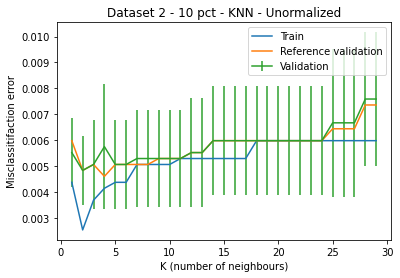

10 percent of data
Best cross validation accuracy : 0.997 found with K = 1 (UNORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 member

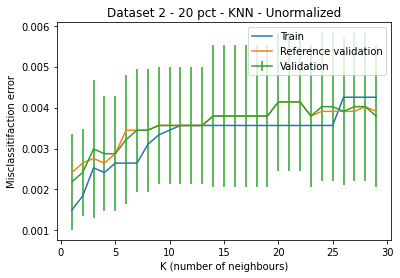

20 percent of data
Best cross validation accuracy : 1.000 found with K = 1 (UNORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

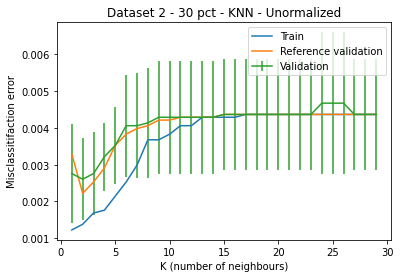

30 percent of data
Best cross validation accuracy : 0.999 found with K = 1 (UNORMALIZED)
-------------------------------------------------------------------------------------------



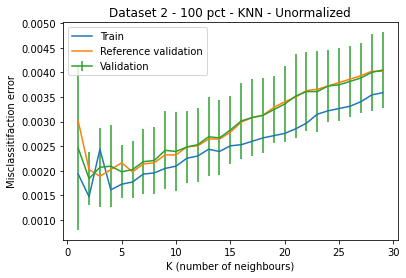

100 percent of data
Best cross validation accuracy : 0.999 found with K = 1 (UNORMALIZED)





/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 member

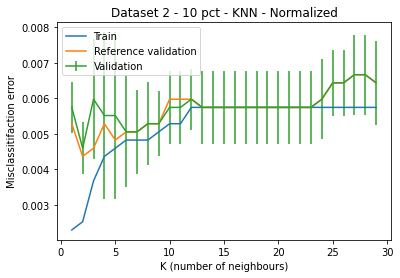

10 percent of data
Best cross validation accuracy : 0.998 found with K = 4 (NORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

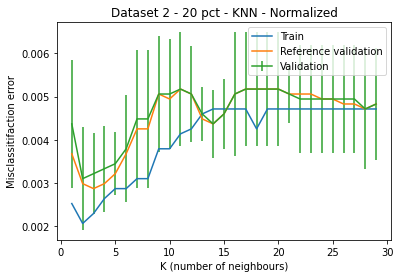

20 percent of data
Best cross validation accuracy : 0.999 found with K = 2 (NORMALIZED)
-------------------------------------------------------------------------------------------



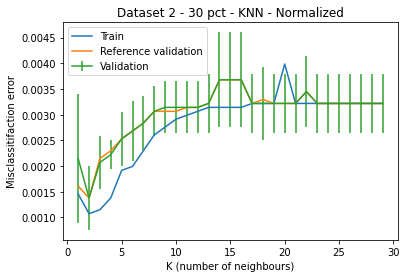

30 percent of data
Best cross validation accuracy : 1.000 found with K = 1 (NORMALIZED)
-------------------------------------------------------------------------------------------



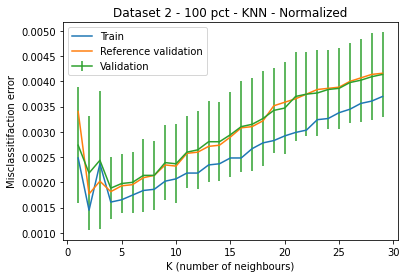

100 percent of data
Best cross validation accuracy : 0.999 found with K = 1 (NORMALIZED)


In [33]:
# Data splits (UNORMALIZED)
x, y = dataset2_trn_full.iloc[:,:-1].to_numpy(), dataset2_trn_full['LABEL'].to_numpy()

# Split further for testing purposes (growing samples)
data_30 = dataset2_trn_full.sample(frac=0.30)
x_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['LABEL'].to_numpy()

data_20 = dataset2_trn_full.sample(frac=0.20)
x_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['LABEL'].to_numpy()

data_10 = dataset2_trn_full.sample(frac=0.10)
x_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['LABEL'].to_numpy()

# With 10% of data
best_acc, best_k = findBestK(x_10, y_10, 'Dataset 2 - 10 pct - KNN - Unormalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_k = findBestK(x_20, y_20, 'Dataset 2 - 20 pct - KNN - Unormalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_k = findBestK(x_30, y_30, 'Dataset 2 - 30 pct - KNN - Unormalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_k = findBestK(x, y, 'Dataset 2 - 100 pct - KNN - Unormalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (UNORMALIZED)')
print('\n\n')

#########################################
# Normalized data (10%, 20%, 30%, 100%) #
#########################################

# Split the data
x_normalized_dataset_2, y_normalized_dataset_2 = normalized_dataset_2.iloc[:,:-1].to_numpy(), normalized_dataset_2['LABEL'].to_numpy()

# Split further for testing purposes (growing samples)
normalized_data_30 = normalized_dataset_2.sample(frac=0.30)
x_30_normalized, y_30_normalized = normalized_data_30.iloc[:,:-1].to_numpy(), normalized_data_30['LABEL'].to_numpy()

normalized_data_20 = normalized_dataset_2.sample(frac=0.20)
x_20_normalized, y_20_normalized = normalized_data_20.iloc[:,:-1].to_numpy(), normalized_data_20['LABEL'].to_numpy()

normalized_data_10 = normalized_dataset_2.sample(frac=0.10)
x_10_normalized, y_10_normalized = normalized_data_10.iloc[:,:-1].to_numpy(), normalized_data_10['LABEL'].to_numpy()

# With 10% of data
best_acc, best_k = findBestK(x_10_normalized, y_10_normalized, 'Dataset 2 - 10 pct - KNN - Normalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_k = findBestK(x_20_normalized, y_20_normalized, 'Dataset 2 - 20 pct - KNN - Normalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_k = findBestK(x_30_normalized, y_30_normalized, 'Dataset 2 - 30 pct - KNN - Normalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_k = findBestK(x_normalized_dataset_2, y_normalized_dataset_2, 'Dataset 2 - 100 pct - KNN - Normalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (NORMALIZED)')

## Note
Although 0.999 accuracy with K=1 on normalized data is better than 0.998, we choose 0.998 accuracy as our best model to prevent overfitting.
This result was found with configuration: unormalized, k=4.

### 6.1.1 Apply model on test (dataset 2)

In [34]:
x_test, y_test = dataset2_test.iloc[:,:-1].to_numpy(), dataset2_test['LABEL'].to_numpy()

# 100 %
best_model = neighbors.KNeighborsClassifier(n_neighbors=11, weights='distance')
best_model.fit(x, y)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 30 %
best_model = neighbors.KNeighborsClassifier(n_neighbors=1)
best_model.fit(x_30, y_30)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 20 %
best_model = neighbors.KNeighborsClassifier(n_neighbors=2)
best_model.fit(x_20, y_20)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 10 %
best_model = neighbors.KNeighborsClassifier(n_neighbors=1)
best_model.fit(x_10, y_10)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

[[11478     0     0     0     0     0     0]
 [    1     9     0     3     0     0     0]
 [   14     0    23     2     0     0     0]
 [    0     0     0  2155     0     0     0]
 [    1     0     0     0   808     0     0]
 [    0     0     2     1     0     1     0]
 [    2     0     0     0     0     0     0]] 0.998
[[11477     0     0     1     0     0     0]
 [    0    10     0     3     0     0     0]
 [   15     0    24     0     0     0     0]
 [    0     0     0  2155     0     0     0]
 [    1     0     0     0   808     0     0]
 [    0     0     1     3     0     0     0]
 [    2     0     0     0     0     0     0]] 0.998
[[11460     0    18     0     0     0     0]
 [    4     6     0     3     0     0     0]
 [   14     0    21     3     1     0     0]
 [    0     0     0  2155     0     0     0]
 [    1     0     0     0   808     0     0]
 [    0     0     2     2     0     0     0]
 [    1     0     1     0     0     0     0]] 0.997
[[11458     0    20     0     0   

Accuracy of the KNN model with test data is 99.8%, as expected.

# 7. Decision Tree

## 7.1 - Dataset 1

In [35]:
## Rajoute find best criteria ici

In [36]:
'''# Data splits (UNORMALIZED)
x, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()

# Split further for testing purposes (growing samples)
data_30 = train_encoded_1.sample(frac=0.30)
x_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()

data_20 = train_encoded_1.sample(frac=0.20)
x_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()

data_10 = train_encoded_1.sample(frac=0.10)
x_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepth(x_10, y_10, 'Dataset 1 - 10 pct - DT - Unormalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepth(x_20, y_20, 'Dataset 1 - 20 pct - DT - Unormalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepth(x_30, y_30, 'Dataset 1 - 30 pct - DT - Unormalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepth(x, y, 'Dataset 1 - 100 pct - DT - Unormalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('\n\n')

#########################################
# Normalized data (10%, 20%, 30%, 100%) #
#########################################

# Split the data
x_normalized, y_normalized = normalized_dataset_1.iloc[:,:-1].to_numpy(), normalized_dataset_1['over-50K'].to_numpy()

# Split further for testing purposes (growing samples)
normalized_data_30 = normalized_dataset_1.sample(frac=0.30)
x_30_normalized, y_30_normalized = normalized_data_30.iloc[:,:-1].to_numpy(), normalized_data_30['over-50K'].to_numpy()

normalized_data_20 = normalized_dataset_1.sample(frac=0.20)
x_20_normalized, y_20_normalized = normalized_data_20.iloc[:,:-1].to_numpy(), normalized_data_20['over-50K'].to_numpy()

normalized_data_10 = normalized_dataset_1.sample(frac=0.10)
x_10_normalized, y_10_normalized = normalized_data_10.iloc[:,:-1].to_numpy(), normalized_data_10['over-50K'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepth(x_10_normalized, y_10_normalized, 'Dataset 1 - 10 pct - DT - Normalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepth(x_20_normalized, y_20_normalized, 'Dataset 1 - 20 pct - DT - Normalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepth(x_30_normalized, y_30_normalized, 'Dataset 1 - 30 pct - DT - Normalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepth(x_normalized, y_normalized, 'Dataset 1 - 100 pct - DT - Normalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')'''

"# Data splits (UNORMALIZED)\nx, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()\n\n# Split further for testing purposes (growing samples)\ndata_30 = train_encoded_1.sample(frac=0.30)\nx_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()\n\ndata_20 = train_encoded_1.sample(frac=0.20)\nx_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()\n\ndata_10 = train_encoded_1.sample(frac=0.10)\nx_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()\n\n# With 10% of data\nbest_acc, best_depth = findBestDepth(x_10, y_10, 'Dataset 1 - 10 pct - DT - Unormalized')\nprint('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')\nprint('-------------------------------------------------------------------------------------------\n')\n\n# With 20% of data\nbest_acc, best_depth = findBestDepth(x_20, y_20, 'Dataset 1 - 20 pct - DT - Unormalized'

## Results
Best accuracy for full dataset is 86.2% with depth 10 on unormalized data

## Testing with Gini index (criterion)

In [37]:
'''# Data splits (UNORMALIZED)
x, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()

# Split further for testing purposes (growing samples)
data_30 = train_encoded_1.sample(frac=0.30)
x_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()

data_20 = train_encoded_1.sample(frac=0.20)
x_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()

data_10 = train_encoded_1.sample(frac=0.10)
x_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepthWithGini(x_10, y_10, 'Dataset 1 - 10 pct - DT with Gini - Unormalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepthWithGini(x_20, y_20,  'Dataset 1 - 20 pct - DT with Gini - Unormalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepthWithGini(x_30, y_30,  'Dataset 1 - 30 pct - DT with Gini - Unormalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepthWithGini(x, y, 'Dataset 1 - 100 pct - DT with Gini - Unormalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('\n\n')

#########################################
# Normalized data (10%, 20%, 30%, 100%) #
#########################################

# Split the data
x_normalized, y_normalized = normalized_dataset_1.iloc[:,:-1].to_numpy(), normalized_dataset_1['over-50K'].to_numpy()

# Split further for testing purposes (growing samples)
normalized_data_30 = normalized_dataset_1.sample(frac=0.30)
x_30_normalized, y_30_normalized = normalized_data_30.iloc[:,:-1].to_numpy(), normalized_data_30['over-50K'].to_numpy()

normalized_data_20 = normalized_dataset_1.sample(frac=0.20)
x_20_normalized, y_20_normalized = normalized_data_20.iloc[:,:-1].to_numpy(), normalized_data_20['over-50K'].to_numpy()

normalized_data_10 = normalized_dataset_1.sample(frac=0.10)
x_10_normalized, y_10_normalized = normalized_data_10.iloc[:,:-1].to_numpy(), normalized_data_10['over-50K'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepthWithGini(x_10_normalized, y_10_normalized, 'Dataset 1 - 10 pct - DT with Gini - Normalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepthWithGini(x_20_normalized, y_20_normalized, 'Dataset 1 - 20 pct - DT with Gini - Normalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepthWithGini(x_30_normalized, y_30_normalized, 'Dataset 1 - 30 pct - DT with Gini - Normalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepthWithGini(x_normalized, y_normalized, 'Dataset 1 - 100 pct - DT with Gini - Normalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')'''

"# Data splits (UNORMALIZED)\nx, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()\n\n# Split further for testing purposes (growing samples)\ndata_30 = train_encoded_1.sample(frac=0.30)\nx_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()\n\ndata_20 = train_encoded_1.sample(frac=0.20)\nx_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()\n\ndata_10 = train_encoded_1.sample(frac=0.10)\nx_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()\n\n# With 10% of data\nbest_acc, best_depth = findBestDepthWithGini(x_10, y_10, 'Dataset 1 - 10 pct - DT with Gini - Unormalized')\nprint('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')\nprint('-------------------------------------------------------------------------------------------\n')\n\n# With 20% of data\nbest_acc, best_depth = findBestDepthWithGini(x_20, y_20,  'Dataset 1 -

### Note
We do note get better accuracy with Gini index criterion

## Testing with Entropy criterion

In [38]:
'''# Data splits (UNORMALIZED)
x, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()

# Split further for testing purposes (growing samples)
data_30 = train_encoded_1.sample(frac=0.30)
x_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()

data_20 = train_encoded_1.sample(frac=0.20)
x_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()

data_10 = train_encoded_1.sample(frac=0.10)
x_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepthWithEntropy(x_10, y_10, 'Dataset 1 - 10 pct - DT with Entropy - Unormalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepthWithEntropy(x_20, y_20, 'Dataset 1 - 20 pct - DT with Entropy - Unormalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepthWithEntropy(x_30, y_30, 'Dataset 1 - 30 pct - DT with Entropy - Unormalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepthWithEntropy(x, y, 'Dataset 1 - 100 pct - DT with Entropy - Unormalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('\n\n')

#########################################
# Normalized data (10%, 20%, 30%, 100%) #
#########################################

# Split the data
x_normalized, y_normalized = normalized_dataset_1.iloc[:,:-1].to_numpy(), normalized_dataset_1['over-50K'].to_numpy()

# Split further for testing purposes (growing samples)
normalized_data_30 = normalized_dataset_1.sample(frac=0.30)
x_30_normalized, y_30_normalized = normalized_data_30.iloc[:,:-1].to_numpy(), normalized_data_30['over-50K'].to_numpy()

normalized_data_20 = normalized_dataset_1.sample(frac=0.20)
x_20_normalized, y_20_normalized = normalized_data_20.iloc[:,:-1].to_numpy(), normalized_data_20['over-50K'].to_numpy()

normalized_data_10 = normalized_dataset_1.sample(frac=0.10)
x_10_normalized, y_10_normalized = normalized_data_10.iloc[:,:-1].to_numpy(), normalized_data_10['over-50K'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepthWithEntropy(x_10_normalized, y_10_normalized, 'Dataset 1 - 10 pct - DT with Entropy - Normalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepthWithEntropy(x_20_normalized, y_20_normalized, 'Dataset 1 - 20 pct - DT with Entropy - Normalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepthWithEntropy(x_30_normalized, y_30_normalized, 'Dataset 1 - 30 pct - DT with Entropy - Normalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepthWithEntropy(x_normalized, y_normalized, 'Dataset 1 - 100 pct - DT with Entropy - Normalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')'''

"# Data splits (UNORMALIZED)\nx, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()\n\n# Split further for testing purposes (growing samples)\ndata_30 = train_encoded_1.sample(frac=0.30)\nx_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()\n\ndata_20 = train_encoded_1.sample(frac=0.20)\nx_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()\n\ndata_10 = train_encoded_1.sample(frac=0.10)\nx_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()\n\n# With 10% of data\nbest_acc, best_depth = findBestDepthWithEntropy(x_10, y_10, 'Dataset 1 - 10 pct - DT with Entropy - Unormalized')\nprint('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')\nprint('-------------------------------------------------------------------------------------------\n')\n\n# With 20% of data\nbest_acc, best_depth = findBestDepthWithEntropy(x_20, y_20, 'Dat

### Note
We do note get better accuracy with Entropy criterion

## Apply best model (DT) on dataset 1 (test)

In [39]:
'''x, y = test_encoded_1.iloc[:,:-1].to_numpy(), test_encoded_1['over-50K'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True)

best_model = tree.DecisionTreeClassifier(max_depth=10)
best_model.fit(x_train, y_train)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')'''

"x, y = test_encoded_1.iloc[:,:-1].to_numpy(), test_encoded_1['over-50K'].to_numpy()\nx_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True)\n\nbest_model = tree.DecisionTreeClassifier(max_depth=10)\nbest_model.fit(x_train, y_train)\ntest_pred = best_model.predict(x_test)\n\nacc = np.mean(test_pred == y_test)\nprint(confusion_matrix(y_test, test_pred), f'{acc:.3f}')"

Accuracy on test data is 83.6 (close to expected)

## 7.2 - Dataset 2

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 member

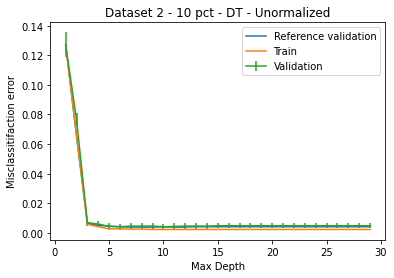

10 percent of data
Best cross validation accuracy : 0.998 found with depth = 5 (UNORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

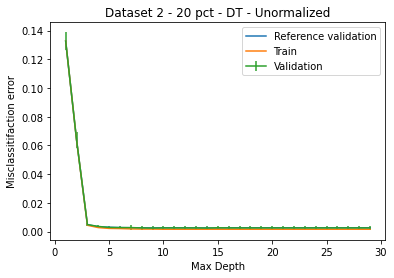

20 percent of data
Best cross validation accuracy : 0.999 found with depth = 7 (UNORMALIZED)
-------------------------------------------------------------------------------------------



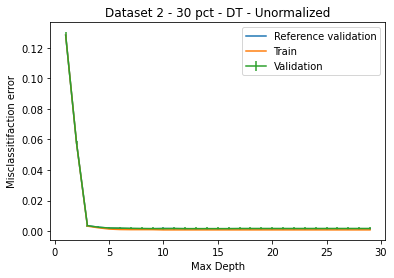

30 percent of data
Best cross validation accuracy : 0.999 found with depth = 6 (UNORMALIZED)
-------------------------------------------------------------------------------------------



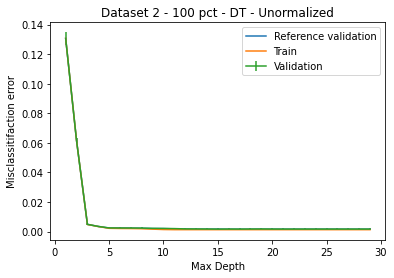

100 percent of data
Best cross validation accuracy : 0.999 found with depth = 14 (UNORMALIZED)





/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

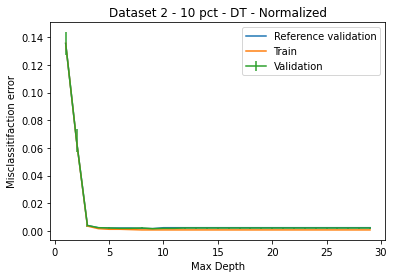

10 percent of data
Best cross validation accuracy : 0.999 found with depth = 4 (NORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

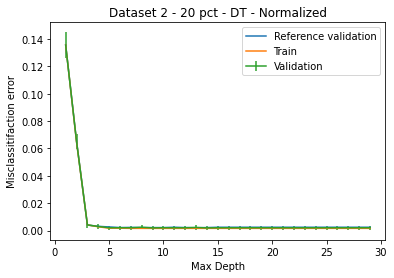

20 percent of data
Best cross validation accuracy : 1.000 found with depth = 5 (NORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

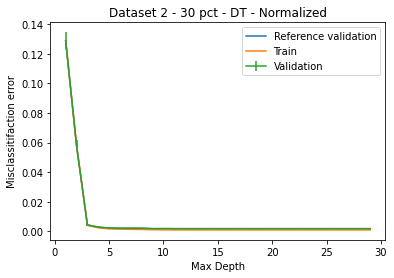

30 percent of data
Best cross validation accuracy : 0.999 found with depth = 9 (NORMALIZED)
-------------------------------------------------------------------------------------------



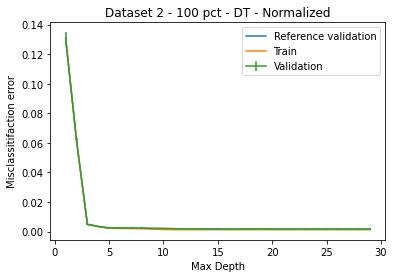

100 percent of data
Best cross validation accuracy : 0.999 found with depth = 14 (NORMALIZED)


In [40]:
# Data splits (UNORMALIZED)
x, y = dataset2_trn_full.iloc[:,:-1].to_numpy(), dataset2_trn_full['LABEL'].to_numpy()

# Split further for testing purposes (growing samples)
data_30 = dataset2_trn_full.sample(frac=0.30)
x_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['LABEL'].to_numpy()

data_20 = dataset2_trn_full.sample(frac=0.20)
x_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['LABEL'].to_numpy()

data_10 = dataset2_trn_full.sample(frac=0.10)
x_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['LABEL'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepth(x_10, y_10, 'Dataset 2 - 10 pct - DT - Unormalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepth(x_20, y_20, 'Dataset 2 - 20 pct - DT - Unormalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepth(x_30, y_30, 'Dataset 2 - 30 pct - DT - Unormalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepth(x, y, 'Dataset 2 - 100 pct - DT - Unormalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('\n\n')

#########################################
# Normalized data (10%, 20%, 30%, 100%) #
#########################################

# Split the data
x_normalized_dataset_2, y_normalized_dataset_2 = normalized_dataset_2.iloc[:,:-1].to_numpy(), normalized_dataset_2['LABEL'].to_numpy()

# Split further for testing purposes (growing samples)
normalized_data_30 = normalized_dataset_2.sample(frac=0.30)
x_30_normalized, y_30_normalized = normalized_data_30.iloc[:,:-1].to_numpy(), normalized_data_30['LABEL'].to_numpy()

normalized_data_20 = normalized_dataset_2.sample(frac=0.20)
x_20_normalized, y_20_normalized = normalized_data_20.iloc[:,:-1].to_numpy(), normalized_data_20['LABEL'].to_numpy()

normalized_data_10 = normalized_dataset_2.sample(frac=0.10)
x_10_normalized, y_10_normalized = normalized_data_10.iloc[:,:-1].to_numpy(), normalized_data_10['LABEL'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepth(x_10_normalized, y_10_normalized, 'Dataset 2 - 10 pct - DT - Normalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepth(x_20_normalized, y_20_normalized, 'Dataset 2 - 20 pct - DT - Normalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepth(x_30_normalized, y_30_normalized, 'Dataset 2 - 30 pct - DT - Normalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepth(x_normalized_dataset_2, y_normalized_dataset_2, 'Dataset 2 - 100 pct - DT - Normalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')

## Results
100% accuracy found with unormalized data and depth of 7.

## Results
100% accuracy found with unormalized data and depth of 7. (No change)
For dataset #2 Gini and entropy did not impact the accuracy.

## Testing with Entropy criterion

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 member

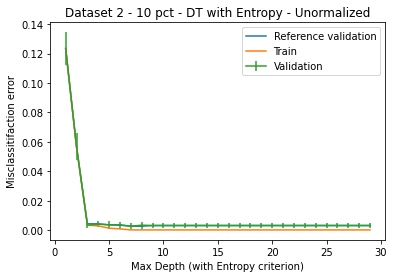

10 percent of data
Best cross validation accuracy : 1.000 found with depth = 5 (UNORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 member

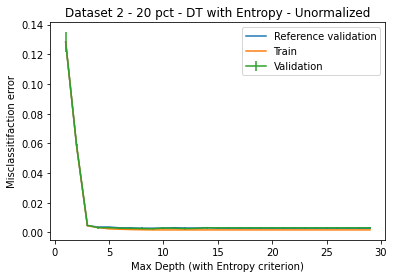

20 percent of data
Best cross validation accuracy : 0.999 found with depth = 6 (UNORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

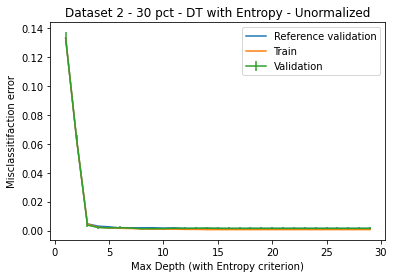

30 percent of data
Best cross validation accuracy : 1.000 found with depth = 8 (UNORMALIZED)
-------------------------------------------------------------------------------------------



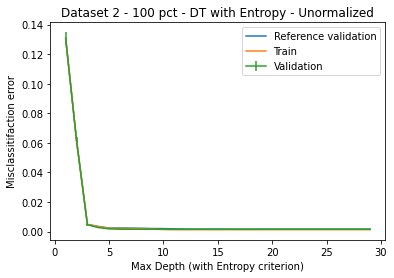

100 percent of data
Best cross validation accuracy : 0.999 found with depth = 6 (UNORMALIZED)





/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

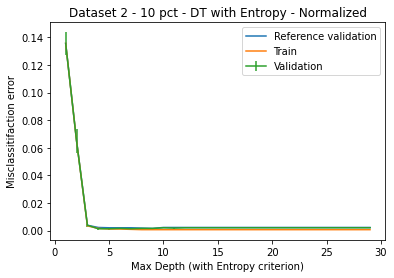

10 percent of data
Best cross validation accuracy : 1.000 found with depth = 4 (NORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

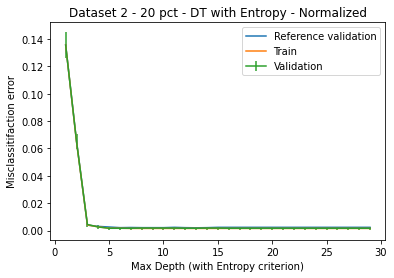

20 percent of data
Best cross validation accuracy : 1.000 found with depth = 5 (NORMALIZED)
-------------------------------------------------------------------------------------------



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 member

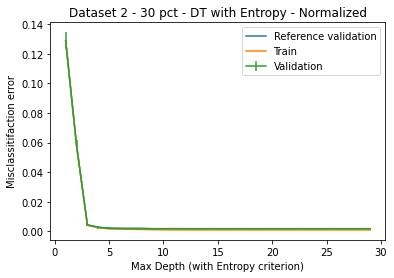

30 percent of data
Best cross validation accuracy : 0.999 found with depth = 8 (NORMALIZED)
-------------------------------------------------------------------------------------------



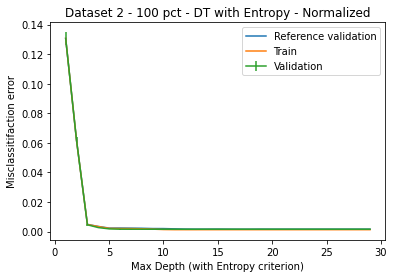

100 percent of data
Best cross validation accuracy : 0.999 found with depth = 6 (NORMALIZED)


In [42]:
# Data splits (UNORMALIZED)
x, y = dataset2_trn_full.iloc[:,:-1].to_numpy(), dataset2_trn_full['LABEL'].to_numpy()

# Split further for testing purposes (growing samples)
data_30 = dataset2_trn_full.sample(frac=0.30)
x_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['LABEL'].to_numpy()

data_20 = dataset2_trn_full.sample(frac=0.20)
x_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['LABEL'].to_numpy()

data_10 = dataset2_trn_full.sample(frac=0.10)
x_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['LABEL'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepthWithEntropy(x_10, y_10, 'Dataset 2 - 10 pct - DT with Entropy - Unormalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepthWithEntropy(x_20, y_20, 'Dataset 2 - 20 pct - DT with Entropy - Unormalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepthWithEntropy(x_30, y_30, 'Dataset 2 - 30 pct - DT with Entropy - Unormalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepthWithEntropy(x, y, 'Dataset 2 - 100 pct - DT with Entropy - Unormalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (UNORMALIZED)')
print('\n\n')

#########################################
# Normalized data (10%, 20%, 30%, 100%) #
#########################################

# Split the data
x_normalized_dataset_2, y_normalized_dataset_2 = normalized_dataset_2.iloc[:,:-1].to_numpy(), normalized_dataset_2['LABEL'].to_numpy()

# Split further for testing purposes (growing samples)
normalized_data_30 = normalized_dataset_2.sample(frac=0.30)
x_30_normalized, y_30_normalized = normalized_data_30.iloc[:,:-1].to_numpy(), normalized_data_30['LABEL'].to_numpy()

normalized_data_20 = normalized_dataset_2.sample(frac=0.20)
x_20_normalized, y_20_normalized = normalized_data_20.iloc[:,:-1].to_numpy(), normalized_data_20['LABEL'].to_numpy()

normalized_data_10 = normalized_dataset_2.sample(frac=0.10)
x_10_normalized, y_10_normalized = normalized_data_10.iloc[:,:-1].to_numpy(), normalized_data_10['LABEL'].to_numpy()

# With 10% of data
best_acc, best_depth = findBestDepthWithEntropy(x_10_normalized, y_10_normalized, 'Dataset 2 - 10 pct - DT with Entropy - Normalized')
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_depth = findBestDepthWithEntropy(x_20_normalized, y_20_normalized, 'Dataset 2 - 20 pct - DT with Entropy - Normalized')
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_depth = findBestDepthWithEntropy(x_30_normalized, y_30_normalized, 'Dataset 2 - 30 pct - DT with Entropy - Normalized')
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_depth = findBestDepthWithEntropy(x_normalized_dataset_2, y_normalized_dataset_2, 'Dataset 2 - 100 pct - DT with Entropy - Normalized')
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with depth = {best_depth} (NORMALIZED)')

## Results
100% accuracy found with unormalized data and depth of 7. (No change)

## Apply best model DT on dataset 2

In [44]:
x_test, y_test = dataset2_test.iloc[:,:-1].to_numpy(), dataset2_test['LABEL'].to_numpy()

# 100 %
best_model = tree.DecisionTreeClassifier(max_depth=6)
best_model.fit(x, y)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 30 %
best_model = tree.DecisionTreeClassifier(max_depth=5, criterion='entropy')
best_model.fit(x_30, y_30)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 20 %
best_model = tree.DecisionTreeClassifier(max_depth=5, criterion='entropy')
best_model.fit(x_20, y_20)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

# 10 %
best_model = tree.DecisionTreeClassifier(max_depth=4)
best_model.fit(x_10, y_10)
test_pred = best_model.predict(x_test)

acc = np.mean(test_pred == y_test)
print(confusion_matrix(y_test, test_pred), f'{acc:.3f}')

[[11478     0     0     0     0     0     0]
 [    8     4     0     1     0     0     0]
 [   15     0    24     0     0     0     0]
 [    7     0     0  2148     0     0     0]
 [    1     0     0     0   808     0     0]
 [    0     0     4     0     0     0     0]
 [    2     0     0     0     0     0     0]] 0.997
[[11478     0     0     0     0     0     0]
 [    0    11     0     2     0     0     0]
 [   14     1    24     0     0     0     0]
 [    0     0     4  2151     0     0     0]
 [    1     0     0     0   808     0     0]
 [    0     0     4     0     0     0     0]
 [    2     0     0     0     0     0     0]] 0.998
[[11478     0     0     0     0     0     0]
 [    1     9     3     0     0     0     0]
 [   15     2    22     0     0     0     0]
 [    1    10     0  2144     0     0     0]
 [    1     0     0     0   808     0     0]
 [    0     0     4     0     0     0     0]
 [    2     0     0     0     0     0     0]] 0.997
[[11478     0     0     0     0   

Accuracy of 100% (as expected)